In [0]:
#Automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import matplotlib.pyplot as plt

In [0]:
PATH = 'fastai/data/dogscats/'
sz = 224

In [0]:
# using bash together with Python
# inspect the first few images
files = !ls {PATH}valid/cats | head
files

['cat.10016.jpg',
 'cat.1001.jpg',
 'cat.10026.jpg',
 'cat.10048.jpg',
 'cat.10050.jpg',
 'cat.10064.jpg',
 'cat.10071.jpg',
 'cat.10091.jpg',
 'cat.10103.jpg',
 'cat.10104.jpg']

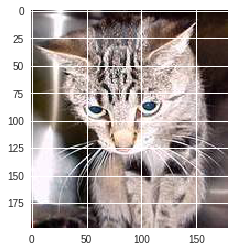

In [0]:
# Python 3.6 format string
img = plt.imread(f"{PATH}valid/cats/{files[0]}")
plt.imshow(img)

In [0]:
img.shape

(198, 179, 3)

In [0]:
img[:4,:4].shape

(4, 4, 3)

### Train Model

In [0]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, 
                                      tfms = tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute = True)
# learning rate = 0.01, epoch = 3
# learning rate, epoch needs to be decided
learn.fit(0.01, 3)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 71988706.29it/s]


100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.050551   0.026343   0.9895    
    1      0.046645   0.026593   0.9905    
    2      0.033877   0.025945   0.9905    



[array([0.02595]), 0.9905]

#### Analysis of Results

In [0]:
# one-hot labels for validation data
# data.val_y
# classes labels for validation data
# data.classes

array([0, 0, 0, ..., 1, 1, 1])

In [0]:
# Give prediction for validation set
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [0]:
# Predictions are given for validation sets
np.exp(log_preds[:10])

array([[0.99997, 0.00003],
       [0.99967, 0.00033],
       [0.9998 , 0.0002 ],
       [0.99966, 0.00034],
       [0.99651, 0.00349],
       [0.99999, 0.00001],
       [1.     , 0.     ],
       [1.     , 0.     ],
       [0.99979, 0.00021],
       [0.99995, 0.00005]], dtype=float32)

In [0]:
preds = np.argmax(log_preds, axis = 1)
probs = np.exp(log_preds[:,1])

In [0]:
def rand_by_mask(mask):
  return np.random.choice(np.where(mask)[0], 4, replace = False)

def rand_by_correct(is_correct):
  return rand_by_mask((preds == data.val_y) == is_correct)

In [0]:
def plot_val_with_title(idxs, titles):
  imgs = np.stack([data.val_ds[x][0] for x in idxs])
  title_probs = [probs[x] for x in idxs]
  print(title)
  return plots(data.val_ds.denorm(imgs, rows = 1, title = probs))

In [0]:
def plots(ims, figsize = (12, 6), rows = 1, titles = None):
  f = plt.figure(figsize = figsize)
  for i in range(len(ims)):
    sp = f.add_subplot(rows, len(ims)//rows, i+1)
    sp.axis('Off')
    if titles is not None:
      sp.set_title(titles[i], fontsize = 16)
    plt.imshow(ims[i]);

In [0]:
def load_img_id(ds, idx):
  return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
  imgs = [load_img_id(data.val_ds, x) for x in idxs]
  title_probs = [probs[x] for x in idxs]
  print(title)
  return plots(imgs, rows = 1, titles = title_probs, figsize = (16, 8))

Correctly Classified


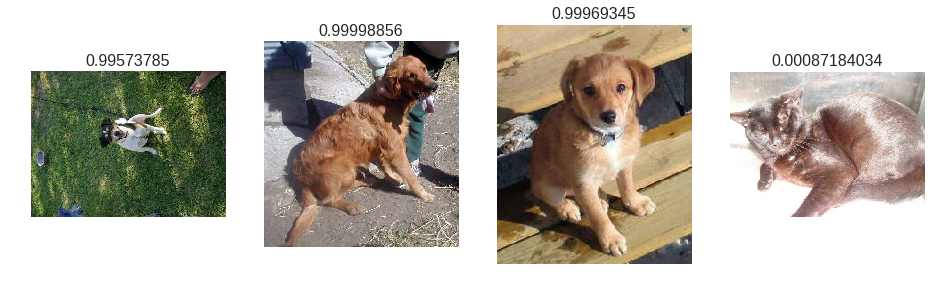

In [0]:
# A few examples of correctly classified (dog)
plot_val_with_title(rand_by_correct(True), "Correctly Classified")

Incorrectly Classified


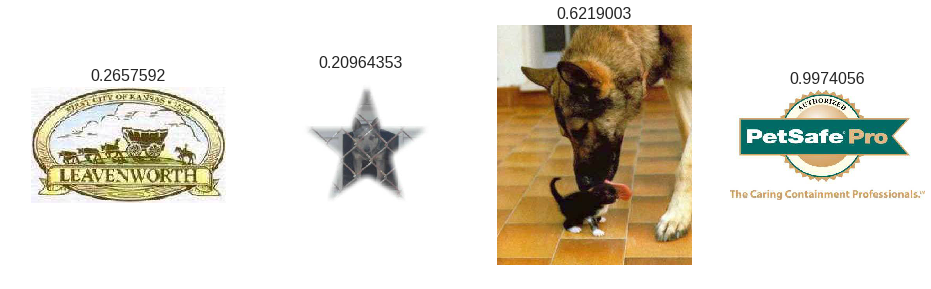

In [0]:
# A few examples of incorrectly classified (dog)
plot_val_with_title(rand_by_correct(False), "Incorrectly Classified")

In [0]:
def most_by_mask(mask, mult):
  idxs = np.where(mask)[0]
  return idxs[np.argsort(mult * probs[idxs][:4])]

def most_by_correct(y, is_correct):
  mult = -1 if (y==1)==is_correct else 1
  return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most correct cats


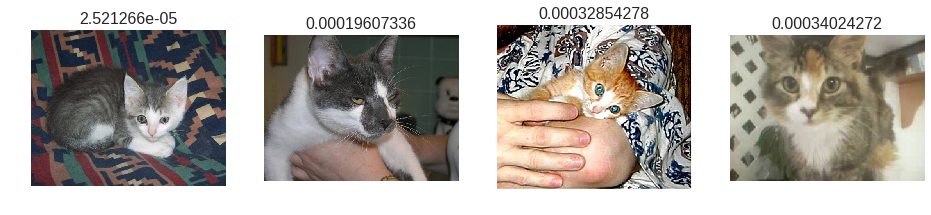

In [0]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most Correct Dogs


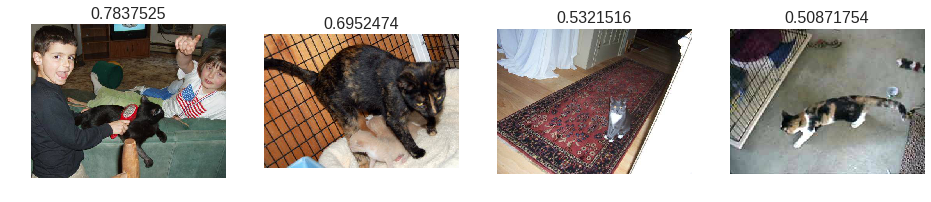

In [0]:
plot_val_with_title(most_by_correct(1, True), "Most Correct Dogs")

Most incorrect cats


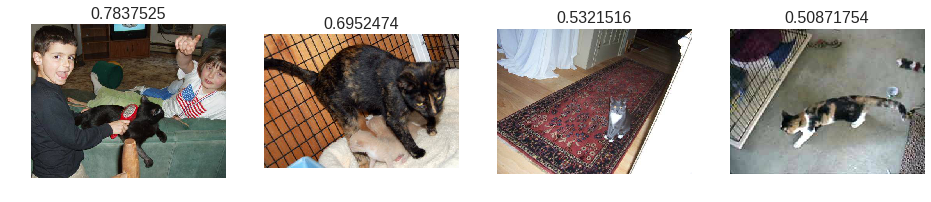

In [0]:
plot_val_with_title(most_by_correct(0, False), "Most Incorrect Cats")

Most Uncertain Predictions


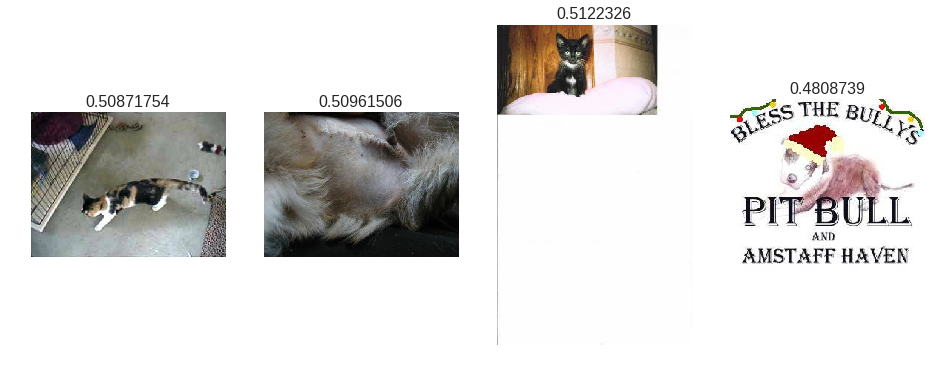

In [0]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most Uncertain Predictions")

### Deciding Learning Rate

In [0]:
learn = ConvLearner.pretrained(arch, data, precompute = True)

In [0]:
lrf = learn.lr_find()

 82%|████████▎ | 297/360 [00:08<00:01, 40.94it/s, loss=0.458]


In [0]:
# Can be linear search or exponential search
learn.sched.plot_lr()

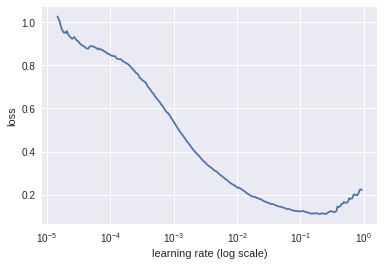

In [0]:
# Find the learning rate with highest decrease in loss function
learn.sched.plot()

#### Questions
1. What is precomputing?
2. 